Name: **Luong Nguyen**  
Student ID: **1504210**  

## Introduction to Deep Learning 

### Session03: Boston housing with k-fold validation
____

**Import the packages needed for this assignment**

In [1]:
# import packages
import numpy as np
from keras import models, layers
import matplotlib.pyplot as plt
from keras.datasets import boston_housing

Using TensorFlow backend.


**Load data**

In [2]:
(x_train, y_train), (x_test, y_test) =  boston_housing.load_data()

**Explore data**

x_train shape: (404, 13)
y_train shape: (404,)
x_test shape: (102, 13)
y_test shape: (102,)

A sample of x_train: 
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
And the corresponding y_train value: 15.2

Mean of y_train: 22.395
Min of y_train: 5.000
Max of y_train: 50.000


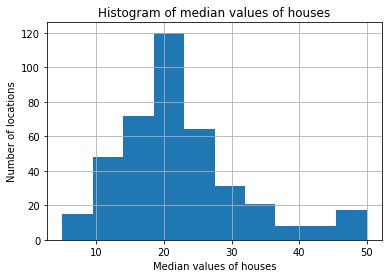

In [3]:
print("x_train shape: %s" % (str(x_train.shape)))
print("y_train shape: %s" % (str(y_train.shape)))
print("x_test shape: %s" % (str(x_test.shape)))
print("y_test shape: %s" % (str(y_test.shape)))
print("\nA sample of x_train: \n" + str(x_train[0]))
print("And the corresponding y_train value: " + str(y_train[0]))
mean_y = np.mean(y_train)
max_y = np.max(y_train)
min_y = np.min(y_train)
print("\nMean of y_train: %.3f" % (mean_y))
print("Min of y_train: %.3f" % (min_y))
print("Max of y_train: %.3f" % (max_y))

plt.hist(y_train, 10)
plt.ylabel('Number of locations')
plt.xlabel('Median values of houses')
plt.title('Histogram of median values of houses')
plt.grid(True)

As we can see, the features of this dataset have different ranges, so we need to standardize data before feeding it to the models. 

**Standardize data**

In [4]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

print("\nA standardized row data: \n" + str(x_train[0]))


A standardized row data: 
[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


**Linear regression**

Before building neural networks, let's see how linear regression works on this problem.  

In [5]:
model = models.Sequential()
model.add(layers.Dense(1, input_shape=(x_train.shape[1],)))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [6]:
hist = model.fit(x_train, y_train, epochs=200, batch_size=1, verbose=0, validation_data=(x_test,y_test))

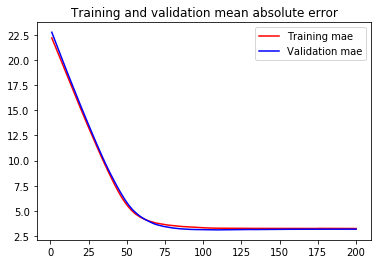

In [7]:
train_mae_hist = hist.history['mean_absolute_error']
val_mae_hist = hist.history['val_mean_absolute_error']

epochs = range(1, len(train_mae_hist) + 1)

plt.plot(epochs, train_mae_hist, 'r', label='Training mae')
plt.plot(epochs, val_mae_hist, 'b', label='Validation mae')
plt.title('Training and validation mean absolute error')
plt.legend()

plt.show()

In [8]:
val_mse, val_mae = model.evaluate(x_test, y_test, verbose=0)
print("With linear regression, the predictions are off by ${:.2f} on average, {:.2f}%  of the mean value."
      .format(val_mae * 1000, val_mae / mean_y * 100)) 

With linear regression, the predictions are off by $3177.88 on average, 14.19%  of the mean value.


**Deep network without K-fold validation**

In [36]:
# model from Chollet book - chapter 3.6.3
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Without K-fold validation, we just split `x_train` into `x_train_partial` and `x_val`, adjusting the parameters and then train the final model on the whole training set evaluate its performance on the initial test data.

In [48]:
x_train_partial = x_train[:303]
y_train_partial = y_train[:303]

x_val = x_train[303:]
y_val = y_train[303:]

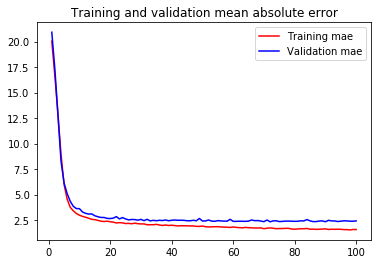

In [50]:
model = build_model()
hist = model.fit(x_train_partial, y_train_partial, epochs=100, batch_size=16, verbose=0, validation_data=(x_val,y_val))

train_mae_hist = hist.history['mean_absolute_error']
val_mae_hist = hist.history['val_mean_absolute_error']

epochs = range(1, len(train_mae_hist) + 1)

plt.plot(epochs, train_mae_hist, 'r', label='Training mae')
plt.plot(epochs, val_mae_hist, 'b', label='Validation mae')
plt.title('Training and validation mean absolute error')
plt.legend()

plt.show()

Validation mae stops improving significantly after around 40 epochs. We'll train the model with 40 epochs on the whole training set.  

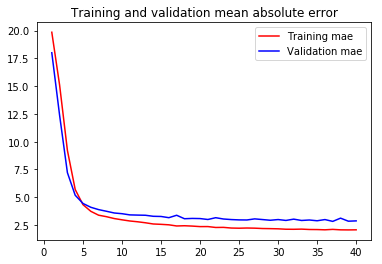

In [51]:
model = build_model()
hist = model.fit(x_train, y_train, epochs=40, batch_size=16, verbose=0, validation_data=(x_test,y_test))

train_mae_hist = hist.history['mean_absolute_error']
val_mae_hist = hist.history['val_mean_absolute_error']

epochs = range(1, len(train_mae_hist) + 1)

plt.plot(epochs, train_mae_hist, 'r', label='Training mae')
plt.plot(epochs, val_mae_hist, 'b', label='Validation mae')
plt.title('Training and validation mean absolute error')
plt.legend()

plt.show()

In [52]:
val_mse, val_mae = model.evaluate(x_test, y_test, verbose=0)
print("With a 2-hidden-layer network without K-fold validation, the predictions are off by ${:.2f} on average,\n {:.2f}%  of the mean value."
      .format(val_mae * 1000, val_mae / mean_y * 100)) 

With a 2-hidden-layer network without K-fold validation, the predictions are off by $2871.26 on average,
 12.82%  of the mean value.


**Deep network with K-fold validation**

Code from the Chollet book

In [53]:
k = 4
num_val_samples = len(x_train) // k

In [54]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


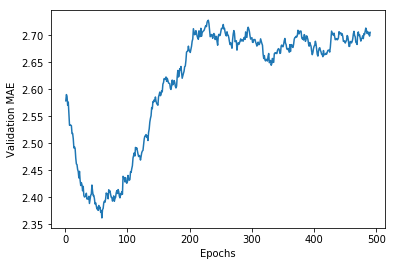

In [55]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

From the chart we estimate the lowest `mae` is around 60 epochs.

In [78]:
model = build_model()
hist = model.fit(x_train, y_train, epochs=60, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(x_test,y_test, verbose = 0)
print("mae = " + str(test_mae_score))

mae = 2.6165883026871026


In [81]:
print("With K-fold validation, the predictions are off by ${:.2f} on average, {:.2f}%  of the mean value."
      .format(test_mae_score * 1000, test_mae_score / mean_y * 100)) 

With K-fold validation, the predictions are off by $2616.59 on average, 11.68%  of the mean value.


The result is slightly better than without K-fold validation (`mae = $2871.26`).